In [3]:
!curl -o /tmp/stackex.txt https://raw.githubusercontent.com/Raphtory/Data/main/sx_reordered.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3968k  100 3968k    0     0  5350k      0 --:--:-- --:--:-- --:--:-- 5385k


In [1]:
import pandas as pd
from pyraphtory.context import PyRaphtory
from pyraphtory.input import ImmutableString
from pyraphtory.input import GraphBuilder
from pyraphtory.spouts import FileSpout
from pyraphtory.sources import CSVEdgeListSource
from pyraphtory.sources import Source
from pyraphtory.graph import Row

structure_file = "/tmp/stackex.txt"

ctx = PyRaphtory.local()

In [6]:
graph = ctx.new_graph()

spout = FileSpout(structure_file)
builder = CSVEdgeListSource(spout,source_index=0,target_index=1,time_index=2,delimiter=" ",header=False)

graph.load(builder)

com.raphtory.api.analysis.graphview.PyDeployedTemporalGraph@22791b75

In [20]:
windows = [86400, 604800, 2592000, 15780000]
df_nodes = graph \
    .walk(86400) \
    .window(windows) \
    .execute(ctx.algorithms.generic.NodeEdgeCount)\
    .to_df(["nodes", "edges_dir", "edges_undir", "temporal_edges"])

In [31]:
df_nodes.tail(20)

,timestamp,window,nodes,edges_dir,edges_undir,temporal_edges
9388,1456983412,15780000,4799,12048,12048,12048
9389,1456983412,2592000,1487,2221,2221,2221
9390,1456983412,604800,509,526,526,526
9391,1456983412,86400,121,78,78,78
9392,1457069812,15780000,4814,12051,12051,12051
9393,1457069812,2592000,1490,2234,2234,2234
9394,1457069812,604800,508,522,522,522
9395,1457069812,86400,119,82,82,82
9396,1457156212,15780000,4811,12057,12057,12057
9397,1457156212,2592000,1497,2222,2222,2222


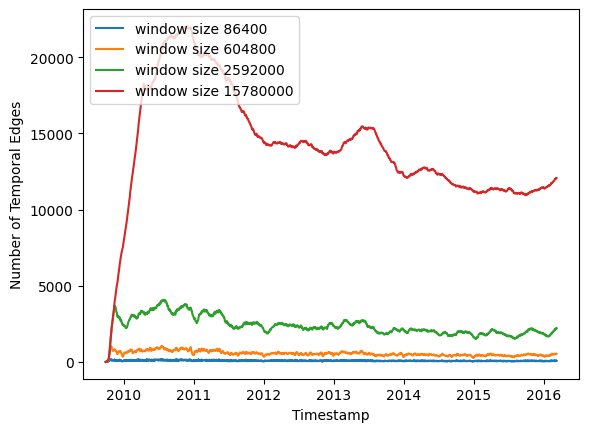

In [30]:
import matplotlib.pyplot as plt
import datetime as dt

fig, ax = plt.subplots()
ax.set_xlabel("Timestamp")
ax.set_ylabel("Number of Temporal Edges")

for window in windows:
    df_sub = df_nodes[df_nodes["window"] == window]
    dates = df_sub["timestamp"].apply(dt.datetime.fromtimestamp)
    ax.plot(dates, df_sub.temporal_edges, label = "window size "+str(window))

ax.legend(loc= "upper left")
plt.show()

In [19]:
from pyraphtory.scala.implicits.numeric import Long

df_community = graph \
    .execute(ctx.algorithms.generic.community.LPA[Long]())\
    .to_df(["name", "community"])

In [36]:
df_clustering = graph \
    .walk(86400) \
    .window(windows) \
    .execute(ctx.algorithms.generic.motif.GlobalClusteringCoefficient)\
    .to_df(["avgCluster", "globalCluster"])

In [41]:
df_clustering.tail()

,timestamp,window,avgCluster,globalCluster
9403,1457242612,86400,0.032258,0.0
9404,1457261724,15780000,0.041456,0.0
9405,1457261724,2592000,0.025554,0.0
9406,1457261724,604800,0.011908,0.0
9407,1457261724,86400,0.023102,0.0


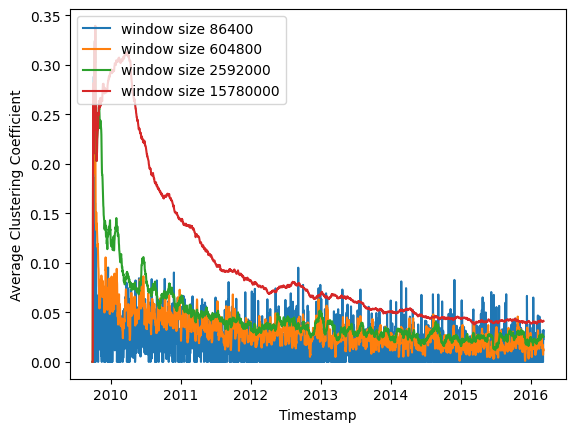

In [42]:
import matplotlib.pyplot as plt
import datetime as dt

fig, ax = plt.subplots()
ax.set_xlabel("Timestamp")
ax.set_ylabel("Average Clustering Coefficient")

for window in windows:
    df_sub = df_clustering[df_clustering["window"] == window]
    dates = df_sub["timestamp"].apply(dt.datetime.fromtimestamp)
    ax.plot(dates, df_sub.avgCluster, label = "window size "+str(window))

ax.legend(loc= "upper left")
plt.show()